In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os

import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from 과제1 import df_product_category_name_translation, df_products
from 과제2 import merge_oicsr

제외 전 주문수: 98328
제외 후 주문수: 98320
📌 단계별 평균 배송시간(일 단위)
purchase_to_approved     0.44
approved_to_carrier      2.85
carrier_to_customer      9.18
purchase_to_customer    12.47
dtype: float64

📌 ETA 대비 KPI
총 배송건수          112259.00
정시배송율               91.36
지연배송율                8.64
평균 지연일(지연건만)        10.50
dtype: float64
📌 주(state)별 배송 성과
                  주문수  평균_전체배송시간  정시배송율  평균_지연일
customer_state                                 
AC                 92      20.72   96.0   18.67
AL                439      24.41   76.0    9.87
AM                165      26.39   96.0   24.40
AP                 81      28.29   95.0   96.33
BA               3781      19.23   85.0   11.81
CE               1469      21.00   83.0   14.70
DF               2400      12.96   92.0    7.89
ES               2243      15.67   88.0   10.80
GO               2321      15.40   91.0   12.20
MA                823      21.65   80.0    9.87
MG              13070      11.98   94.0    8.41
MS                815      15.56   90.

과제 3: 상품 카테고리별 수요 예측 및 재고 관리 인사이트
시간에 따른 상품 카테고리별 판매 트렌드를 분석하고, 계절성 패턴을 파악하여 향후 수요 예측과 재고 관리 전략을 수립 
merge 

In [18]:
# 1) products 붙이기
merge_oicsrp = merge_oicsr.merge(
    df_products.drop_duplicates(subset="product_id"),
    on="product_id",
    how="left"
)

# 2) 카테고리 번역 붙이기
merge_final = merge_oicsrp.merge(
    df_product_category_name_translation.drop_duplicates(subset="product_category_name"),
    on="product_category_name",
    how="left"
)

# 병합 후 결측치 확인
# print("=== 결측치 확인 ===")
# print(merge_final.isnull().sum().sort_values(ascending=False).head(10))
 
# 카테고리 영문명 등 결측치 Unknown 처리)
# merge_final['product_category_name_english'] = merge_final['product_category_name_english'].fillna('Unknown')

merge_final.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112267 entries, 0 to 112266
Data columns (total 45 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       112267 non-null  object        
 1   customer_id                    112267 non-null  object        
 2   order_status                   112267 non-null  object        
 3   order_purchase_timestamp       112267 non-null  datetime64[ns]
 4   order_approved_at              112252 non-null  datetime64[ns]
 5   order_delivered_carrier_date   111073 non-null  datetime64[ns]
 6   order_delivered_customer_date  109815 non-null  datetime64[ns]
 7   order_estimated_delivery_date  112267 non-null  datetime64[ns]
 8   purchase_to_approved           112252 non-null  float64       
 9   approved_to_carrier            111058 non-null  float64       
 10  carrier_to_customer            109814 non-null  float64       
 11  

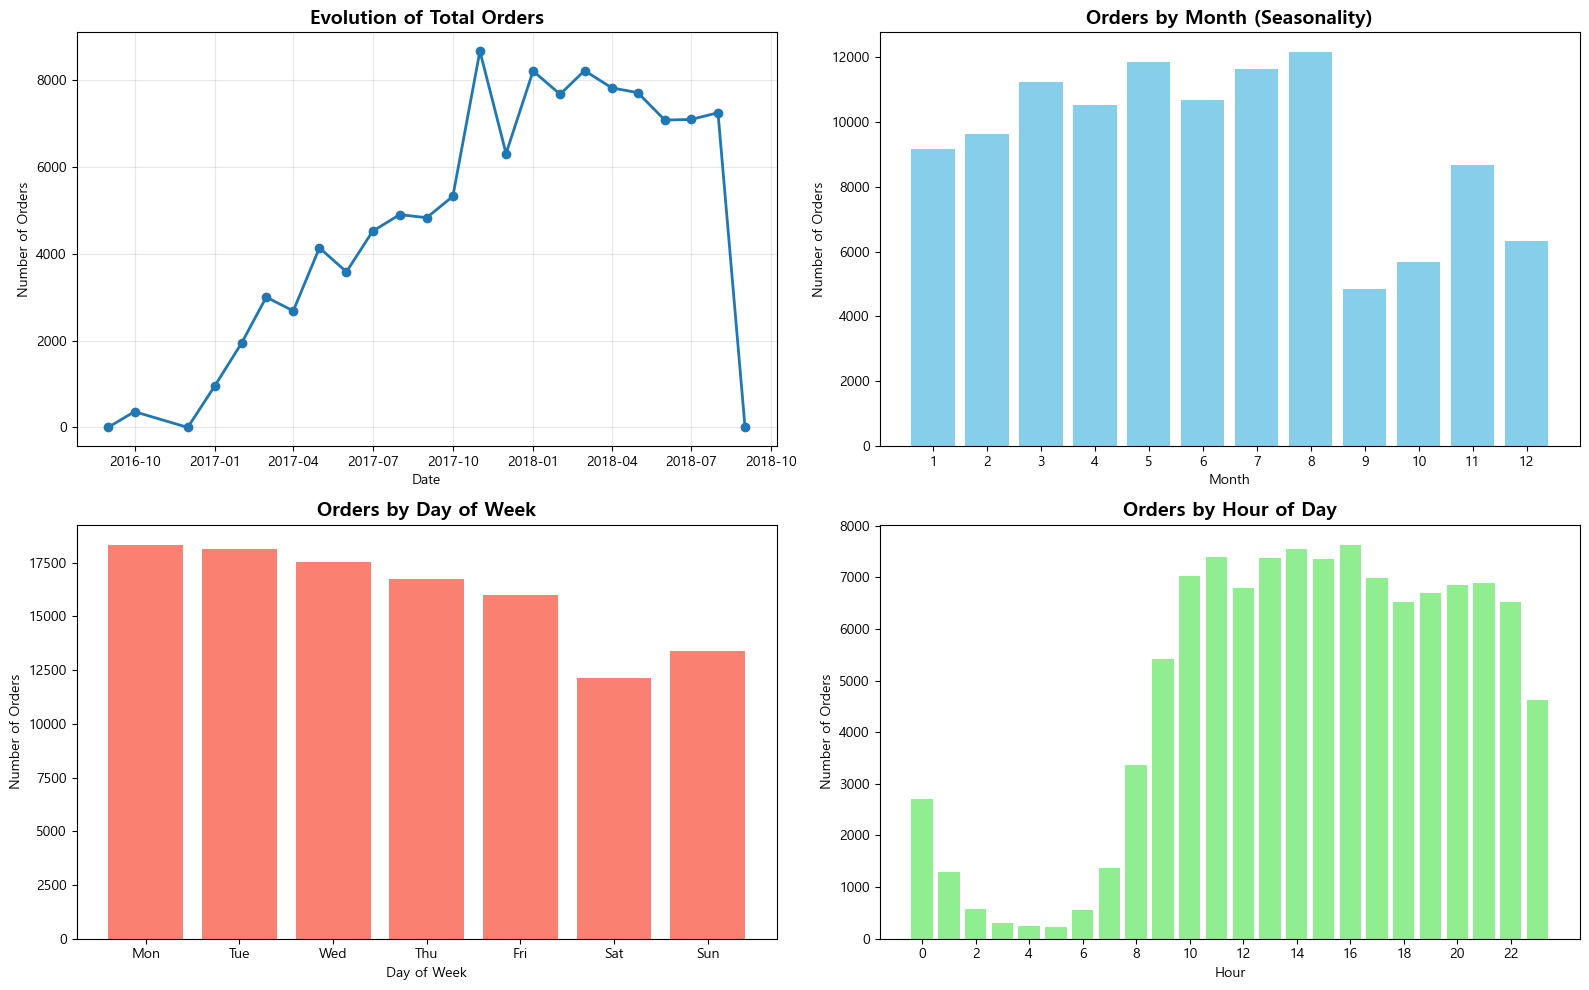

=== 주문량 통계 ===

월별 최다 주문: 8월 (12146건)
요일별 최다 주문: Monday (18341건)
시간대별 최다 주문: 16시 (7634건)


In [23]:
# 시간 기반 파생 변수 생성
merge_final['year'] = merge_final['order_purchase_timestamp'].dt.year
merge_final['month'] = merge_final['order_purchase_timestamp'].dt.month
merge_final['weekday'] = merge_final['order_purchase_timestamp'].dt.day_name()
merge_final['hour'] = merge_final['order_purchase_timestamp'].dt.hour
merge_final['year_month'] = merge_final['order_purchase_timestamp'].dt.to_period('M')

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) 월별 주문량 추이 (성장 추세)
monthly_orders = merge_final.groupby('year_month').size()
monthly_orders.index = monthly_orders.index.to_timestamp()
axes[0, 0].plot(monthly_orders.index, monthly_orders.values, marker='o', linewidth=2)
axes[0, 0].set_title('Evolution of Total Orders', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Number of Orders')
axes[0, 0].grid(alpha=0.3)

# 2) 월별 주문량 (계절성)
month_orders = merge_final.groupby('month').size()
axes[0, 1].bar(month_orders.index, month_orders.values, color='skyblue')
axes[0, 1].set_title('Orders by Month (Seasonality)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Orders')
axes[0, 1].set_xticks(range(1, 13))

# 3) 요일별 주문량
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_orders = merge_final['weekday'].value_counts().reindex(weekday_order)
axes[1, 0].bar(range(7), weekday_orders.values, color='salmon')
axes[1, 0].set_title('Orders by Day of Week', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Orders')
axes[1, 0].set_xticks(range(7))
axes[1, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# 4) 시간대별 주문량
hour_orders = merge_final.groupby('hour').size()
axes[1, 1].bar(hour_orders.index, hour_orders.values, color='lightgreen')
axes[1, 1].set_title('Orders by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Number of Orders')
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

# 통계 출력
print("=== 주문량 통계 ===")
print(f"\n월별 최다 주문: {month_orders.idxmax()}월 ({month_orders.max()}건)")
print(f"요일별 최다 주문: {weekday_orders.idxmax()} ({weekday_orders.max()}건)")
print(f"시간대별 최다 주문: {hour_orders.idxmax()}시 ({hour_orders.max()}건)")

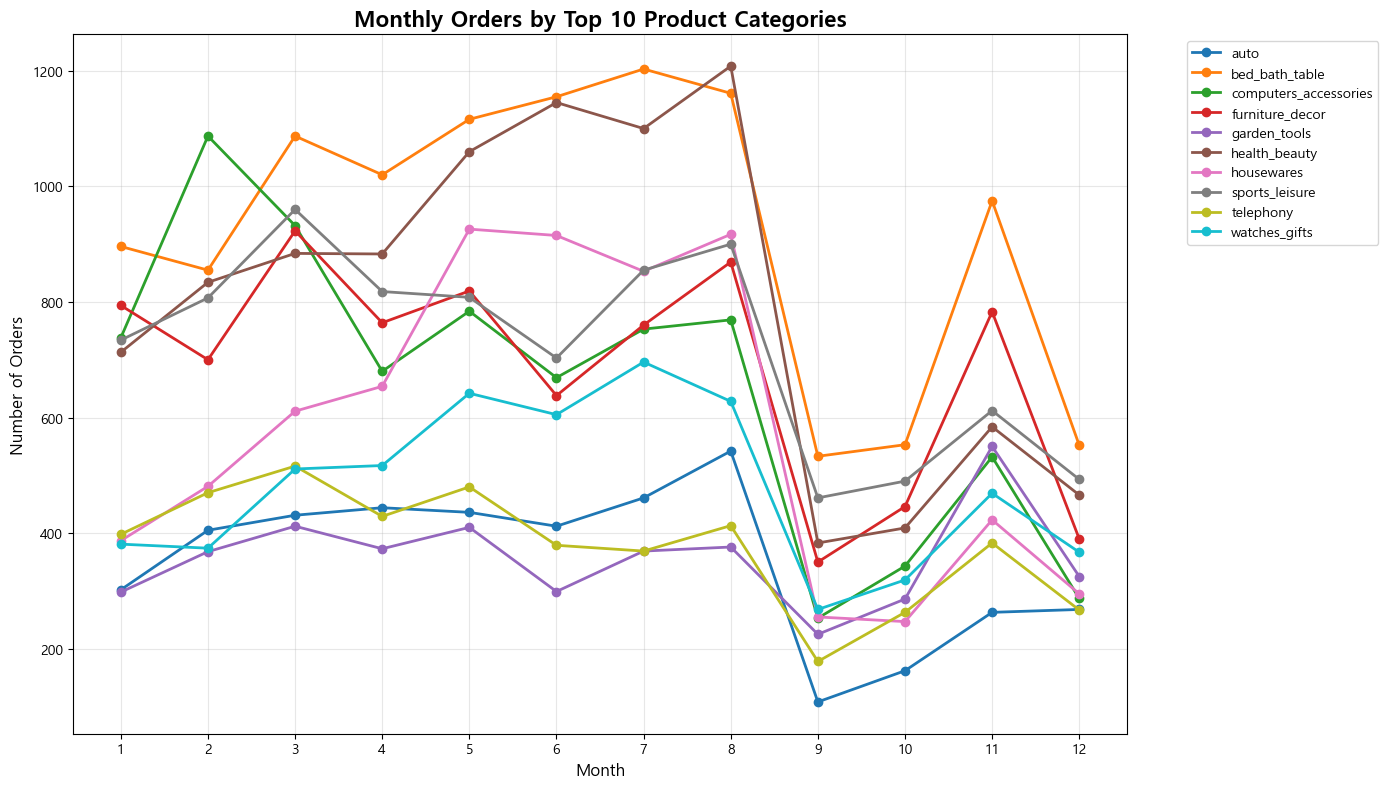

=== 카테고리별 수요 패턴 ===
bed_bath_table                 | 최대:  7월 | 최소:  9월
health_beauty                  | 최대:  8월 | 최소:  9월
sports_leisure                 | 최대:  3월 | 최소:  9월
furniture_decor                | 최대:  3월 | 최소:  9월
computers_accessories          | 최대:  2월 | 최소:  9월
housewares                     | 최대:  5월 | 최소: 10월
watches_gifts                  | 최대:  7월 | 최소:  9월
telephony                      | 최대:  3월 | 최소:  9월
garden_tools                   | 최대: 11월 | 최소:  9월
auto                           | 최대:  8월 | 최소:  9월


In [24]:
# 카테고리별 월별 주문량
category_month = merge_final.groupby(['product_category_name_english', 'month']).size().reset_index(name='orders')

# 상위 10개 카테고리 선정
top_categories = merge_final['product_category_name_english'].value_counts().head(10).index

# 상위 카테고리만 필터링
category_month_top = category_month[category_month['product_category_name_english'].isin(top_categories)]

# 피벗 테이블 생성
pivot = category_month_top.pivot(index='month', columns='product_category_name_english', values='orders')

# 시각화
plt.figure(figsize=(14, 8))
for category in pivot.columns:
    plt.plot(pivot.index, pivot[category], marker='o', label=category, linewidth=2)

plt.title('Monthly Orders by Top 10 Product Categories', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.xticks(range(1, 13))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 카테고리별 최대/최소 수요 월
print("=== 카테고리별 수요 패턴 ===")
for category in top_categories:
    cat_data = category_month[category_month['product_category_name_english'] == category]
    max_month = cat_data.loc[cat_data['orders'].idxmax(), 'month']
    min_month = cat_data.loc[cat_data['orders'].idxmin(), 'month']
    print(f"{category:30s} | 최대: {int(max_month):2d}월 | 최소: {int(min_month):2d}월")

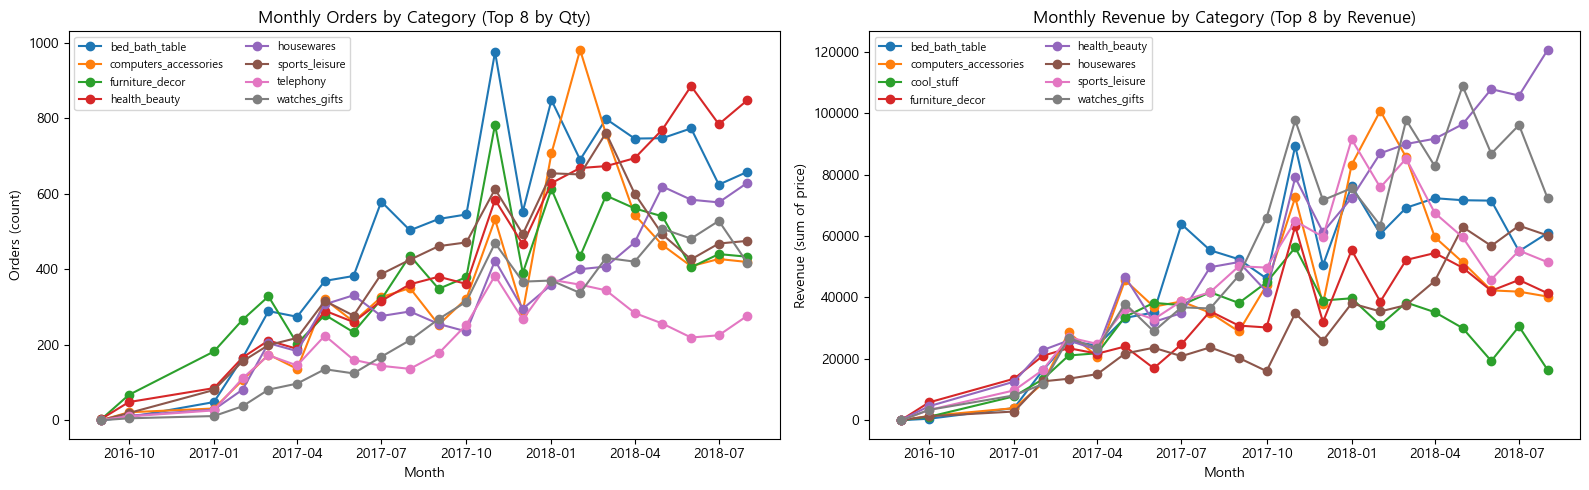

In [25]:
# 1) 월 단위 컬럼 생성
merge_final["month"] = merge_final["order_purchase_timestamp"].values.astype("datetime64[M]")
merge_final["qty"] = 1  # 각 row = 1개 주문 아이템

# 2) 월별 카테고리별 판매량 / 매출 집계
monthly_cat = (
    merge_final.groupby(["month", "product_category_name_english"], as_index=False)
      .agg(qty=("qty", "sum"),
           revenue=("price", "sum"))
      .sort_values(["month", "product_category_name_english"])
)

# 3) Top-N 카테고리 선정 (전체 기간 기준)
N = 8
topN_qty = (monthly_cat.groupby("product_category_name_english")["qty"]
                        .sum().sort_values(ascending=False).head(N).index.tolist())
topN_rev = (monthly_cat.groupby("product_category_name_english")["revenue"]
                        .sum().sort_values(ascending=False).head(N).index.tolist())

# 4) Pivot (판매량 & 매출)
pivot_qty = (monthly_cat[monthly_cat["product_category_name_english"].isin(topN_qty)]
             .pivot(index="month", columns="product_category_name_english", values="qty")
             .fillna(0))

pivot_rev = (monthly_cat[monthly_cat["product_category_name_english"].isin(topN_rev)]
             .pivot(index="month", columns="product_category_name_english", values="revenue")
             .fillna(0))

# 5) 시각화 (1줄에 2개 그래프)
fig, axes = plt.subplots(1, 2, figsize=(16,5))

# (왼쪽) 판매량
for col in pivot_qty.columns:
    axes[0].plot(pivot_qty.index, pivot_qty[col], marker="o", label=col)
axes[0].set_title(f"Monthly Orders by Category (Top {N} by Qty)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Orders (count)")
axes[0].legend(loc="upper left", ncol=2, fontsize=8)

# (오른쪽) 매출액
for col in pivot_rev.columns:
    axes[1].plot(pivot_rev.index, pivot_rev[col], marker="o", label=col)
axes[1].set_title(f"Monthly Revenue by Category (Top {N} by Revenue)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Revenue (sum of price)")
axes[1].legend(loc="upper left", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


C:\Users\mumu1\AppData\Local\Temp\ipykernel_10268\4125091767.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


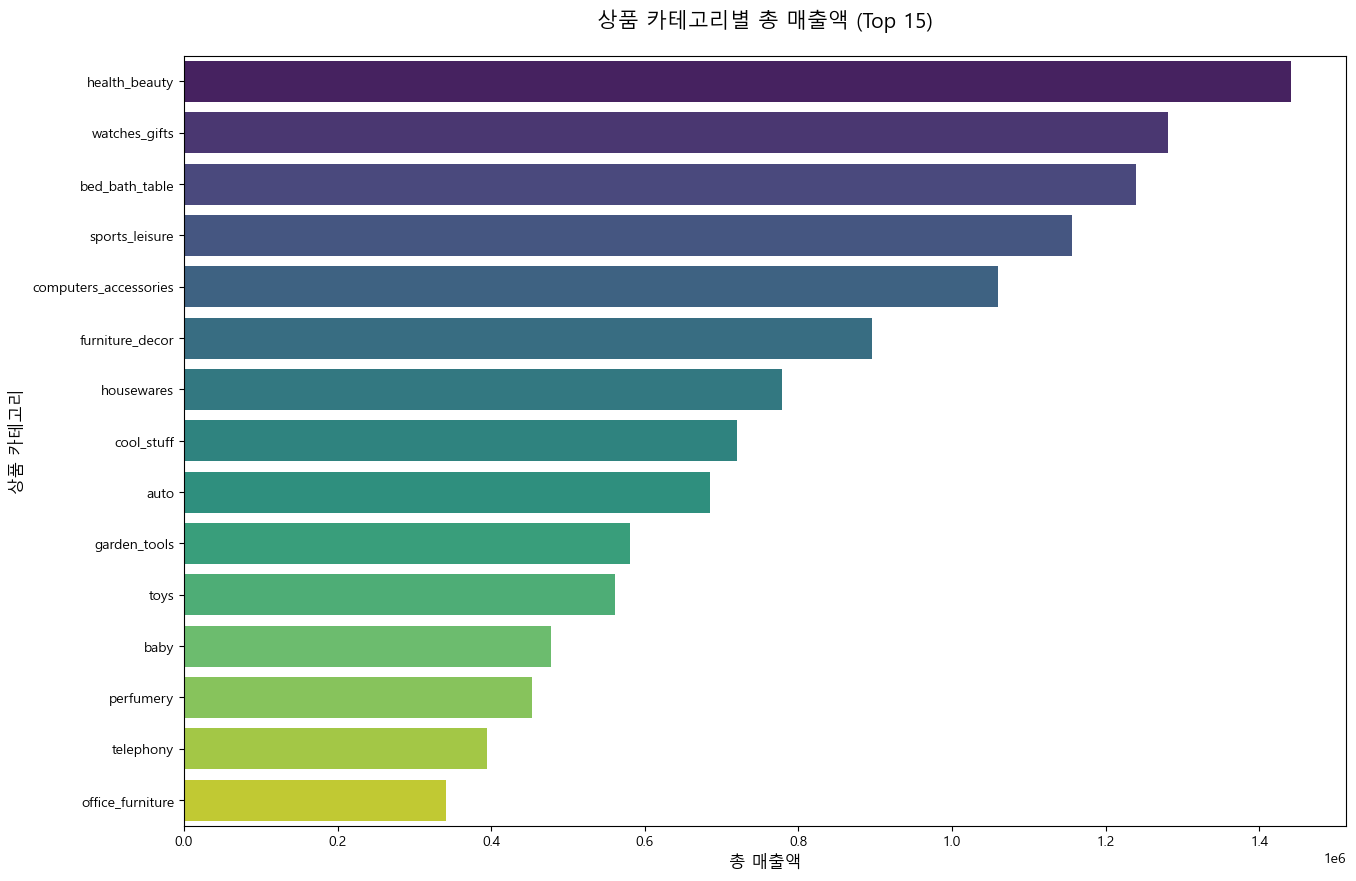

In [28]:
# 카테고리별 총 매출액 계산 

# 1. 'sales_value' 컬럼 생성 (가격 + 배송비)
merge_final['sales_value'] = merge_final['price'] + merge_final['freight_value']

# 2. 카테고리별로 총 매출액을 집계하여 새로운 요약 데이터프레임 생성
category_sales = merge_final.groupby('product_category_name_english')['sales_value'].sum().reset_index()

# 3. '총 매출액'을 기준으로 내림차순 정렬
category_sales_sorted = category_sales.sort_values(by="sales_value", ascending=False)

# 4. 바 그래프 시각화 (요약된 데이터를 사용)
plt.figure(figsize=(15, 10))
sns.barplot(
    data=category_sales_sorted.head(15), # 상위 15개 카테고리 시각화
    x="sales_value",
    y="product_category_name_english",
    palette="viridis"
)
plt.title("상품 카테고리별 총 매출액 (Top 15)", fontsize=15, pad=20)
plt.xlabel("총 매출액", fontsize=12)
plt.ylabel("상품 카테고리", fontsize=12)
plt.show()

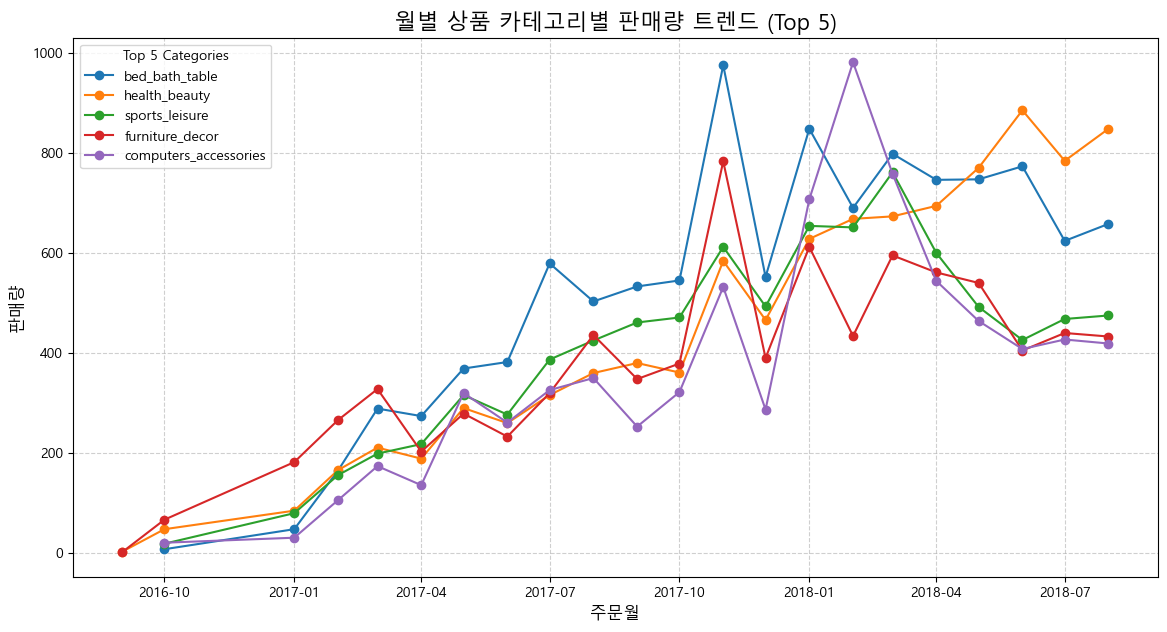

In [30]:
# 1. 월별/카테고리별 판매량 데이터 준비
# 월별/카테고리별 주문 건수를 집계
merge_final['order_month'] = merge_final['order_purchase_timestamp'].dt.to_period('M').dt.to_timestamp()

category_trend_qty = (
    merge_final.groupby(['order_month', 'product_category_name_english'])
    .size()
    .reset_index(name='sales_qty')
)

# 2. 전체 기간 기준, 판매량 Top 5 카테고리 선정
top_categories = (
    category_trend_qty.groupby("product_category_name_english")["sales_qty"]
    .sum()
    .nlargest(5)
    .index
)

# 3. 시각화
plt.figure(figsize=(14, 7))

for cat in top_categories:
    # Top 5에 해당하는 카테고리의 데이터만 필터링
    subset = category_trend_qty[category_trend_qty["product_category_name_english"] == cat]
    # 꺾은선 그래프 그리기
    plt.plot(subset["order_month"], subset["sales_qty"], marker="o", linestyle="-", label=cat)

plt.title("월별 상품 카테고리별 판매량 트렌드 (Top 5)", fontsize=16)
plt.xlabel("주문월", fontsize=12)
plt.ylabel("판매량", fontsize=12)
plt.legend(title="Top 5 Categories")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()